In [ ]:
""" Several line of codes were adapted from a demos 
    from Pennylane.ai from: 
    https://pennylane.ai/qml/demos/tutorial_variational_classifier.html
"""

In [120]:
import gensim
import pandas as pd
import numpy 
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import re
from gensim.models import Word2Vec  
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zhupipi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zhupipi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zhupipi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [4]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

## Data Processing
#### Food or IT dataset, 3 or 4 words per sentence

In [5]:
"""
* Reading raw langauge data.
* This was adapted from Lorenz et al. (2021) QNLP paper.
* From here:
* https://github.com/CQCL/qnlp_lorenz_etal_2021_resources/blob/main/code/mc_task.ipynb
"""
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = line[0]
            # labels.append([t, 1-t])
            labels.append(int(t))
            sentences.append(line[1:].strip())
    return labels, sentences

train_l, train_raw_data = read_data('../datasets/mc_train_data.txt') # Read training data
test_l, test_raw_data   = read_data('../datasets/mc_test_data.txt')  # Read testing data   

In [6]:
# Combine training and test data for pre-processing
train = train_raw_data + test_raw_data
l     = train_l + test_l  # 1 for Food and 0 for IT

In [7]:
# Convert label 0 to -1 and 1 to 1
def shiftlabel(labels):
    label_list = np.array(labels,requires_grad=False)
    label_list = label_list * 2 - np.ones(len(label_list))
    return label_list

In [8]:
Y = shiftlabel(l)

In [9]:
"""
* A raw text pre-processing method.
* This was adapted from Lorenz et al. (2021) QNLP paper.
* From here:
* https://github.com/CQCL/qnlp_lorenz_etal_2021_resources/blob/main/code/mc_task.ipynb
"""
""" Raw data : 'skillful_ADJ person_N prepares_TV application_N'.
    Vocab will contain word and it's part of speech tagger.
    training_data will contain pre processed full sentence : 'skillful person preprares application'.
    train_token will contain tokens for each sentence: ['skillful','person','prepares','application].
    data contains training_data and true labels.
"""

vocab = dict()          
data  = dict()           

training_data = []     
train_token = []

for sent in train:
    words = sent.split() 
    sent_untagged = ''
    for word in words:
        word_untagged, tag = word.split('_')
        vocab[word_untagged] = tag
        sent_untagged += word_untagged + ' '
    sentence = sent_untagged[:-1]
    train_token.append(sentence.split())
    training_data.append(sentence)
    label = np.array([1.0, 0.0]) if sent[0] == '1' else np.array([0.0, 1.0])
    data[sentence] = label

In [12]:
len(vocab) # Vocab size

17

In [13]:
# Using word2vec model 
train_vec = []
for sent in train_token:
    vec = []
    for word in sent:
        vec.append(wv[word])
    train_vec.append(vec)

In [14]:
# Average words embedding to get sentence embedding
def sentence_vector(allsent):
    sent_vec = []
    for sent in allsent:
        all_vec = np.stack(sent,axis=0)
        sent_v = all_vec.mean(axis=0)
        sent_vec.append(sent_v)

    sent_vec = np.stack(sent_vec)

    return sent_vec

In [15]:
train_sent_vec = sentence_vector(train_vec) 

In [16]:
""" Truncated SVD
Adapted from https://weiliu2k.github.io/CITS4012/embeddings/svd.html#using-svd-to-reduce-to-k-dim

"""
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
        # ------------------
        # Write your implementation here.
    M_r = sklearn.decomposition.TruncatedSVD(n_components=k,
                                            algorithm='randomized', 
                                            n_iter=n_iters, 
                                            random_state=None, 
                                            tol=0.0)
    M_reduced = M_r.fit_transform(M)
        # ------------------

    print("Done.")
    return M_reduced

In [17]:
kdim = 4
X = reduce_to_k_dim(train_sent_vec, kdim) # Dimension Reduction 

Running Truncated SVD over 100 words...
Done.


#### AG news group dataset
Consists of class ids 1-4 where 1-World, 2-Sports, 3-Business, 4-Sci/Tech.
We will choose 2 classes: 3-Business and 4-Sci/Tech

In [130]:
ag_raw = pd.read_csv('../datasets/AGNEWS_train.csv',usecols = ['Label','Title']) # Read raw data

In [131]:
ag_1_raw = ag_raw.loc[(ag_raw['Label']== 4) | (ag_raw['Label']== 3)] # Extract only class 3 and 4

In [132]:
# Random select 50 data point from each class to create a perfectly balance dataset
ag_23 = ag_1_raw.groupby('Label').apply(lambda x: x.sample(50,random_state=2)) 
ag_23["Label"].value_counts()

3    50
4    50
Name: Label, dtype: int64

In [34]:
# Convert class 3 to -1 and 4 to 1
ag_label_lst_raw = ag_23['Label'].to_list()  
ag_label_lst = []
for l in ag_label_lst_raw:
    if l == 3:
        ag_label_lst.append(-1)
    else:
        ag_label_lst.append(1)

ag_label = np.array(ag_label_lst,requires_grad=False)

In [35]:
# Tokenization
title_list = []
for i in range(len(ag_23)):
    doc  = nlp(ag_23.iloc[i,1])
    sent = []
    for token in doc:
        if not token.is_punct and not token.is_stop and token.is_alpha:
            if token.ent_type == 0:
                sent.append(token.text.lower())
            else:
                sent.append(token.text)
    title_list.append(sent)

In [36]:
all_token = [ token for lst in title_list for token in lst] # Extract all token
all_token = list(set(all_token))

In [37]:
token_vector   = [wv[token] for token in all_token if token in wv.index_to_key] # Check if each token has a embedding in Word2vec
filtered_token = [token for token in all_token if token in wv.index_to_key]   # Remove token that doesn't have embedding in Word2Vec

In [38]:
len(all_token),len(token_vector),len(filtered_token) # Print orginal vocab size, new vocab size

(455, 443, 443)

In [61]:
# Create a dictionary contain word and embedding
token_vec_zip = zip(filtered_token, token_vector)
token_vec_dict = dict(token_vec_zip)
word_to_vec = pd.DataFrame.from_dict(token_vec_dict, orient='index')
word_to_vec.shape    

(443, 300)

In [63]:
# match each word to its embedding
def vector_matching(sent):
    vector_list = [word_to_vec.loc[token,:].values.flatten().tolist() for token in sent if token in filtered_token]
    return vector_list

In [64]:
vector_list = [vector_matching(sent) for sent in title_list] # Match each word to its embedding

In [75]:
# Check if any sentences that doesn't have any word has vector representation in word2vec
for i in range(len(vector_list)):
    if (len(vector_list[i])) == 0:
        print(i)

In [76]:
ag_vec = sentence_vector(vector_list)  # Produce sentence embedding

In [77]:
ag_X = reduce_to_k_dim(ag_vec, 4) # Dimension reduction

Running Truncated SVD over 100 words...
Done.


### VQC 


##### Experiment list

1. 4 qubits, depth 4, same operator for each layer and random opeartor for each layer.(MC)
2. 4 qubits with different depth: 2,4,6,8. (MC) 
3. 4 and 8 qubits with different depth: 6,8,10 (AG NEWS)
4. Parital measurement on each qubits for 4 and 8 qubits. (MC)


In [112]:
""" To create different circuit, change the number of qubit and depth in this block.
"""

np.random.seed(0)
n_qubits = 4    # Define number of qubit
depth    = 4    # Define number of depth

weights_random = 0.01 * np.random.randn(n_qubits, depth, requires_grad=True)   # Random randomial weights

bias_random = np.array(0.0, requires_grad=True)  # Random bias

print(weights_random, bias_random)

[[ 0.01764052  0.00400157  0.00978738  0.02240893]
 [ 0.01867558 -0.00977278  0.00950088 -0.00151357]
 [-0.00103219  0.00410599  0.00144044  0.01454274]
 [ 0.00761038  0.00121675  0.00443863  0.00333674]] 0.0


In [113]:
# Embedding layer / Encoding layer
def anglembedd(feature_vector):
    qml.AngleEmbedding(features=feature_vector,wires=range(n_qubits),rotation='X')

In [114]:
# Variational block
def layer1(w,nqbits=4,depth=1):
    random.seed(0)
    ls = [qml.RY,qml.RX,qml.RZ]    

    # Apply CNOT to create a full entangle system.
    for i in range(depth):    
        for j in range(nqbits-1):
            qml.CNOT(wires=[j, j+1])
        qml.CNOT(wires=[nqbits-1,0])

        # Define rotation operators. Simply uncomment wanted operator and comment unwanted operator
        for k in range(nqbits):
            # qml.RX(w[k,i],k)
            # qml.RY(w[k,i],k)
            # qml.RZ(w[k,i],k)
            random.choice(ls)(w[k,i],k)

In [125]:
dev = qml.device("default.qubit", wires=n_qubits,shots=None)

# Construct circuit
@qml.qnode(dev)
def circuit(weights, feature_vector,nqbits,depth,qu_index=0):
    anglembedd(feature_vector)              # Angle encoding
    layer1(weights,nqbits,depth)            # Rotation layer

    return qml.expval(qml.PauliZ(qu_index))  # Measurement (measure on observable Pauli Z and return expcted value)

# Introduce bias
def variational_classifier(weights, bias, feature_vector,qu_index=0):
    return circuit(weights, feature_vector,n_qubits,depth,qu_index) + bias

# Cost function Mean Squared Error
def mean_square_loss(true, predictions):
    loss = 0
    for t, p in zip(true, predictions):
        loss += (t - p) ** 2

    return loss / len(true)

# Calculate Accuracy
def accuracy(true, predictions):
    acc = 0
    for t, p in zip(true, predictions):
        if t == p:
            acc += 1

    return acc / len(true)

# Function to compute loss for batch
def cost(weights, bias, train_data, train_label, qu_index):
    predictions = [variational_classifier(weights, bias, x, qu_index) for x in train_data]
    return mean_square_loss(train_label, predictions)

In [126]:
print(qml.draw(circuit,expansion_strategy="device")(weights_random,X[0],n_qubits,depth)) # Draw the circuit

0: ──RX(1.31)─╭C───────╭X──RX(0.02)──╭C───────╭X──RZ(0.00)──╭C───────╭X──RX(0.01)─╭C───────╭X
1: ──RX(0.14)─╰X─╭C────│───RX(0.02)──╰X─╭C────│───RX(-0.01)─╰X─╭C────│───RX(0.01)─╰X─╭C────│─
2: ──RX(0.20)────╰X─╭C─│───RY(-0.00)────╰X─╭C─│───RX(0.00)─────╰X─╭C─│───RZ(0.00)────╰X─╭C─│─
3: ──RX(0.90)───────╰X─╰C──RX(0.01)────────╰X─╰C──RX(0.00)────────╰X─╰C──RY(0.00)───────╰X─╰C

───RZ(0.02)──┤  <Z>
───RY(-0.00)─┤     
───RX(0.01)──┤     
───RY(0.00)──┤     


#### Training Function

In [127]:
""" Training function, takes training data the training label and the following parameters:
    batch_s: batch size, default 5.
    qu_index: qubit index for measurement, default 0.
    step: learning rate, default 0.05. 
    epochs: learning iteration, default 80.
"""

def partMeasure(train_raw,label_raw,batch_s=5,qu_index=0, step=0.05,epochs=80):
    opt            = NesterovMomentumOptimizer(step)      # Optimizer
    batch_size     = batch_s                             # Batch size
    weights        = weights_random
    bias           = bias_random
    train_score    = []
    val_score      = []
    cost_score_raw = []
    
    x_train,x_test,y_train,y_test = train_test_split(train_raw,label_raw, test_size = 0.3, random_state=42) # Split dataset

    for it in range(epochs):

        
        if len(x_train) == batch_size:    
            # Training on full data set        
            X_batch = x_train    
            Y_batch = y_train
        else:
            # Mini batch training
            batch_index = np.random.randint(0, len(x_train), (batch_size,))  
            X_batch = x_train[batch_index]       
            Y_batch = y_train[batch_index]

        # Update the parameters 
        weights, bias, _, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch, qu_index) 

        # Calculate accuracy and loss
        predictions_train = [np.sign(variational_classifier(weights, bias, x, qu_index)) for x in x_train] 
        predictions_val   = [np.sign(variational_classifier(weights, bias, x, qu_index)) for x in x_test]
        
        acc_train = accuracy(y_train, predictions_train)
        acc_val = accuracy(y_test,predictions_val)
        loss_train =  cost(weights, bias, train_raw, label_raw, qu_index)

        print("Epoch: {:3d} | Loss: {:0.5f} | Training Accuracy: {:0.5f} | Valdation Accuracy: {:0.5f}".format(
                it + 1, loss_train, acc_train, acc_val))

        # Append accuracy and loss to lists
        train_score.append(acc_train)
        val_score.append(acc_val)
        cost_score_raw.append(loss_train)

    cost_score = [tensor.item() for tensor in cost_score_raw]
    
    return train_score,val_score,cost_score, weights, bias 

--------
#### Experiment 1. 4 Qubits, 4 Depth with Rx, Ry, Rz and Random(Rx, Ry, Rz) operators on MC dataset.

- To experiment with circuit with different number of qubit and depth, change n_qubits and depth in the earlier block.
- To change rotation operators, change function layer.

In [195]:
# Rx
mc_44rx_train,mc_44rx_val,mc_44rx_loss,mc_44rx_weights,mc_44rx_bias = partMeasure(X,Y,batch_s=70)  

Iter:     1 | Cost: 1.5273744 | Train Accuracy: 0.2571429 | Valdation Accuracy: 0.2666667
Iter:     2 | Cost: 1.4501429 | Train Accuracy: 0.2571429 | Valdation Accuracy: 0.3000000
Iter:     3 | Cost: 1.3292577 | Train Accuracy: 0.2571429 | Valdation Accuracy: 0.2333333
Iter:     4 | Cost: 1.1595619 | Train Accuracy: 0.2857143 | Valdation Accuracy: 0.3333333
Iter:     5 | Cost: 0.9422808 | Train Accuracy: 0.6285714 | Valdation Accuracy: 0.6333333
Iter:     6 | Cost: 0.7158422 | Train Accuracy: 0.9571429 | Valdation Accuracy: 0.9333333
Iter:     7 | Cost: 0.5420204 | Train Accuracy: 1.0000000 | Valdation Accuracy: 1.0000000
Iter:     8 | Cost: 0.4335690 | Train Accuracy: 1.0000000 | Valdation Accuracy: 1.0000000
Iter:     9 | Cost: 0.3729987 | Train Accuracy: 0.9857143 | Valdation Accuracy: 0.9333333
Iter:    10 | Cost: 0.3583632 | Train Accuracy: 0.9857143 | Valdation Accuracy: 0.9000000
Iter:    11 | Cost: 0.3531023 | Train Accuracy: 0.9857143 | Valdation Accuracy: 0.8666667
Iter:    1

In [199]:
# Ry
mc_44_ry_train,mc_44_ry_val,mc_44_ry_loss,mc_44_ry_weights,mc_44_ry_bias = partMeasure(X,Y,batch_s=70)  

Iter:     1 | Cost: 1.5673257 | Train Accuracy: 0.2571429 | Valdation Accuracy: 0.2333333
Iter:     2 | Cost: 1.5655245 | Train Accuracy: 0.1857143 | Valdation Accuracy: 0.2333333
Iter:     3 | Cost: 1.5515224 | Train Accuracy: 0.1285714 | Valdation Accuracy: 0.2333333
Iter:     4 | Cost: 1.5459443 | Train Accuracy: 0.0571429 | Valdation Accuracy: 0.2333333
Iter:     5 | Cost: 1.5455605 | Train Accuracy: 0.0285714 | Valdation Accuracy: 0.1666667
Iter:     6 | Cost: 1.5376383 | Train Accuracy: 0.0142857 | Valdation Accuracy: 0.1666667
Iter:     7 | Cost: 1.5610325 | Train Accuracy: 0.0142857 | Valdation Accuracy: 0.1333333
Iter:     8 | Cost: 1.5640782 | Train Accuracy: 0.0285714 | Valdation Accuracy: 0.1000000
Iter:     9 | Cost: 1.5476474 | Train Accuracy: 0.0000000 | Valdation Accuracy: 0.1333333
Iter:    10 | Cost: 1.5342301 | Train Accuracy: 0.0000000 | Valdation Accuracy: 0.1333333
Iter:    11 | Cost: 1.5270519 | Train Accuracy: 0.0000000 | Valdation Accuracy: 0.1333333
Iter:    1

In [204]:
# Rz
mc_44_rz_train,mc_44_rz_val,mc_44_rz_loss,mc_44_rz_weights,mc_44_rz_bias = partMeasure(X,Y,batch_s=70)

Iter:     1 | Cost: 1.5747291 | Train Accuracy: 0.2285714 | Valdation Accuracy: 0.3000000
Iter:     2 | Cost: 1.5737791 | Train Accuracy: 0.2142857 | Valdation Accuracy: 0.2333333
Iter:     3 | Cost: 1.5632719 | Train Accuracy: 0.1428571 | Valdation Accuracy: 0.2333333
Iter:     4 | Cost: 1.5518542 | Train Accuracy: 0.0428571 | Valdation Accuracy: 0.2000000
Iter:     5 | Cost: 1.5561242 | Train Accuracy: 0.0428571 | Valdation Accuracy: 0.1666667
Iter:     6 | Cost: 1.5899106 | Train Accuracy: 0.0285714 | Valdation Accuracy: 0.1666667
Iter:     7 | Cost: 1.5696577 | Train Accuracy: 0.0000000 | Valdation Accuracy: 0.1333333
Iter:     8 | Cost: 1.5799237 | Train Accuracy: 0.0000000 | Valdation Accuracy: 0.1333333
Iter:     9 | Cost: 1.5757893 | Train Accuracy: 0.0000000 | Valdation Accuracy: 0.1000000
Iter:    10 | Cost: 1.5798447 | Train Accuracy: 0.0000000 | Valdation Accuracy: 0.1000000
Iter:    11 | Cost: 1.5705923 | Train Accuracy: 0.0000000 | Valdation Accuracy: 0.1000000
Iter:    1

In [165]:
# Random
mc_44_rdm_train,mc_44_rdm_val,mc_44_rdm_loss,mc_44_rdm_weights,mc_44_rdm_bias = partMeasure(X,Y,batch_s=70) # for both plot 1 and 2

Iter:     1 | Cost: 1.1430317 | Train Accuracy: 0.5142857 | Valdation Accuracy: 0.6000000
Iter:     2 | Cost: 0.9596689 | Train Accuracy: 0.5142857 | Valdation Accuracy: 0.6000000
Iter:     3 | Cost: 0.7740875 | Train Accuracy: 0.5142857 | Valdation Accuracy: 0.6000000
Iter:     4 | Cost: 0.6368463 | Train Accuracy: 0.8857143 | Valdation Accuracy: 0.8333333
Iter:     5 | Cost: 0.5689498 | Train Accuracy: 0.9714286 | Valdation Accuracy: 0.9000000
Iter:     6 | Cost: 0.5727458 | Train Accuracy: 0.9571429 | Valdation Accuracy: 0.8000000
Iter:     7 | Cost: 0.6035320 | Train Accuracy: 0.8857143 | Valdation Accuracy: 0.7333333
Iter:     8 | Cost: 0.6240723 | Train Accuracy: 0.8000000 | Valdation Accuracy: 0.7000000
Iter:     9 | Cost: 0.6197037 | Train Accuracy: 0.8142857 | Valdation Accuracy: 0.7000000
Iter:    10 | Cost: 0.5802015 | Train Accuracy: 0.9000000 | Valdation Accuracy: 0.7666667
Iter:    11 | Cost: 0.5263697 | Train Accuracy: 0.9142857 | Valdation Accuracy: 0.8000000
Iter:    1

------------------
#### Experiment 2. 4 Qubits, (2,4,6,8) Depth with Random Operators on MC dataset.

In [186]:
# 4 qubits, 2 depths
mc_42_train,mc_42_val,mc_42_loss,mc_42_weights,mc_42_bias = partMeasure(X,Y,batch_s=70)

Iter:     1 | Cost: 1.5408434 | Train Accuracy: 0.2142857 | Valdation Accuracy: 0.2666667
Iter:     2 | Cost: 1.5290913 | Train Accuracy: 0.2000000 | Valdation Accuracy: 0.2666667
Iter:     3 | Cost: 1.5360541 | Train Accuracy: 0.1285714 | Valdation Accuracy: 0.2333333
Iter:     4 | Cost: 1.5094667 | Train Accuracy: 0.0714286 | Valdation Accuracy: 0.2000000
Iter:     5 | Cost: 1.4970128 | Train Accuracy: 0.0285714 | Valdation Accuracy: 0.1666667
Iter:     6 | Cost: 1.4884382 | Train Accuracy: 0.0285714 | Valdation Accuracy: 0.1333333
Iter:     7 | Cost: 1.5099092 | Train Accuracy: 0.0142857 | Valdation Accuracy: 0.1333333
Iter:     8 | Cost: 1.4912912 | Train Accuracy: 0.0000000 | Valdation Accuracy: 0.1333333
Iter:     9 | Cost: 1.4729600 | Train Accuracy: 0.0285714 | Valdation Accuracy: 0.1000000
Iter:    10 | Cost: 1.4344181 | Train Accuracy: 0.0142857 | Valdation Accuracy: 0.1666667
Iter:    11 | Cost: 1.4070367 | Train Accuracy: 0.0714286 | Valdation Accuracy: 0.1333333
Iter:    1

In [ ]:
# 4 qubits, 4 depths
mc_44_rdm_train,mc_44_rdm_val,mc_44_rdm_loss,mc_44_rdm_weights,mc_44_rdm_bias = partMeasure(X,Y,batch_s=70) # for both plot 1 and 2 

Iter:     1 | Cost: 1.5779390 | Train Accuracy: 0.2142857 | Valdation Accuracy: 0.2666667
Iter:     2 | Cost: 1.5529801 | Train Accuracy: 0.2000000 | Valdation Accuracy: 0.2333333
Iter:     3 | Cost: 1.5621825 | Train Accuracy: 0.1142857 | Valdation Accuracy: 0.2333333
Iter:     4 | Cost: 1.5486814 | Train Accuracy: 0.0428571 | Valdation Accuracy: 0.2000000
Iter:     5 | Cost: 1.5663089 | Train Accuracy: 0.0285714 | Valdation Accuracy: 0.2000000
Iter:     6 | Cost: 1.5414391 | Train Accuracy: 0.0142857 | Valdation Accuracy: 0.1666667
Iter:     7 | Cost: 1.5568948 | Train Accuracy: 0.0000000 | Valdation Accuracy: 0.1333333
Iter:     8 | Cost: 1.5697675 | Train Accuracy: 0.0142857 | Valdation Accuracy: 0.1000000
Iter:     9 | Cost: 1.5730521 | Train Accuracy: 0.0000000 | Valdation Accuracy: 0.1000000
Iter:    10 | Cost: 1.5559230 | Train Accuracy: 0.0142857 | Valdation Accuracy: 0.0666667
Iter:    11 | Cost: 1.5523739 | Train Accuracy: 0.0000000 | Valdation Accuracy: 0.1000000
Iter:    1

In [179]:
# 4 qubits, 6 depths
mc_46_train,mc_46_val,mc_46_loss,mc_46_weights,mc_46_bias = partMeasure(X,Y,batch_s=70)

Iter:     1 | Cost: 1.1404202 | Train Accuracy: 0.5142857 | Valdation Accuracy: 0.6000000
Iter:     2 | Cost: 0.9583496 | Train Accuracy: 0.5142857 | Valdation Accuracy: 0.6000000
Iter:     3 | Cost: 0.7832730 | Train Accuracy: 0.5142857 | Valdation Accuracy: 0.6000000
Iter:     4 | Cost: 0.6417912 | Train Accuracy: 0.8571429 | Valdation Accuracy: 0.8000000
Iter:     5 | Cost: 0.5702644 | Train Accuracy: 0.9714286 | Valdation Accuracy: 0.9000000
Iter:     6 | Cost: 0.5748652 | Train Accuracy: 0.9428571 | Valdation Accuracy: 0.8000000
Iter:     7 | Cost: 0.6013325 | Train Accuracy: 0.9000000 | Valdation Accuracy: 0.7666667
Iter:     8 | Cost: 0.6243397 | Train Accuracy: 0.8285714 | Valdation Accuracy: 0.7333333
Iter:     9 | Cost: 0.6187337 | Train Accuracy: 0.8285714 | Valdation Accuracy: 0.7000000
Iter:    10 | Cost: 0.5787511 | Train Accuracy: 0.9000000 | Valdation Accuracy: 0.7333333
Iter:    11 | Cost: 0.5307820 | Train Accuracy: 0.9142857 | Valdation Accuracy: 0.8000000
Iter:    1

In [172]:
# 4 qubits, 8 depths
mc_48_train,mc_48_val,mc_48_loss,mc_48_weights,mc_48_bias = partMeasure(X,Y,batch_s=70)

Iter:     1 | Cost: 1.5413395 | Train Accuracy: 0.2142857 | Valdation Accuracy: 0.2666667
Iter:     2 | Cost: 1.5249795 | Train Accuracy: 0.1571429 | Valdation Accuracy: 0.2333333
Iter:     3 | Cost: 1.5097494 | Train Accuracy: 0.1571429 | Valdation Accuracy: 0.2000000
Iter:     4 | Cost: 1.5113303 | Train Accuracy: 0.0571429 | Valdation Accuracy: 0.1333333
Iter:     5 | Cost: 1.4938585 | Train Accuracy: 0.0142857 | Valdation Accuracy: 0.1666667
Iter:     6 | Cost: 1.4908864 | Train Accuracy: 0.0142857 | Valdation Accuracy: 0.1000000
Iter:     7 | Cost: 1.4638538 | Train Accuracy: 0.0142857 | Valdation Accuracy: 0.1000000
Iter:     8 | Cost: 1.4077072 | Train Accuracy: 0.0428571 | Valdation Accuracy: 0.1000000
Iter:     9 | Cost: 1.3326230 | Train Accuracy: 0.1285714 | Valdation Accuracy: 0.1333333
Iter:    10 | Cost: 1.2219794 | Train Accuracy: 0.2571429 | Valdation Accuracy: 0.2666667
Iter:    11 | Cost: 1.0697040 | Train Accuracy: 0.3285714 | Valdation Accuracy: 0.3000000
Iter:    1

------------
#### Experiment 3. 
- 4 qubits with 6 depths with Random operators on AG News dataset.
- 4 qubits with 8 depths with Random operators on AG News dataset.
- 8 qubits with 8 depths with Random operators on AG News dataset.

In [41]:
# 4 qubits, 6 depths
ag_46_train,ag_46_val,ag_46_loss,ag_46_weights,ag_46_bias = partMeasure(ag_X,ag_label)

Iter:     1 | Cost: 1.6192954 | Train Accuracy: 0.5428571 | Valdation Accuracy: 0.4333333
Iter:     2 | Cost: 1.4253836 | Train Accuracy: 0.5285714 | Valdation Accuracy: 0.4333333
Iter:     3 | Cost: 1.2416024 | Train Accuracy: 0.5285714 | Valdation Accuracy: 0.4333333
Iter:     4 | Cost: 1.0998235 | Train Accuracy: 0.5571429 | Valdation Accuracy: 0.4333333
Iter:     5 | Cost: 1.0215953 | Train Accuracy: 0.5285714 | Valdation Accuracy: 0.5000000
Iter:     6 | Cost: 0.9908636 | Train Accuracy: 0.5857143 | Valdation Accuracy: 0.5666667
Iter:     7 | Cost: 1.0028202 | Train Accuracy: 0.5142857 | Valdation Accuracy: 0.6000000
Iter:     8 | Cost: 1.0137407 | Train Accuracy: 0.4714286 | Valdation Accuracy: 0.5666667
Iter:     9 | Cost: 1.0242312 | Train Accuracy: 0.4714286 | Valdation Accuracy: 0.5666667
Iter:    10 | Cost: 1.0134358 | Train Accuracy: 0.4714286 | Valdation Accuracy: 0.5666667
Iter:    11 | Cost: 1.0021551 | Train Accuracy: 0.4714286 | Valdation Accuracy: 0.5666667
Iter:    1

In [47]:
# 4 qubits, 8 depths
ag_48_train,ag_48_val,ag_48_loss,ag_48_weights,ag_48_bias = partMeasure(ag_X,ag_label)

Iter:     1 | Cost: 1.3166217 | Train Accuracy: 0.5285714 | Valdation Accuracy: 0.4333333
Iter:     2 | Cost: 1.2244139 | Train Accuracy: 0.5285714 | Valdation Accuracy: 0.4333333
Iter:     3 | Cost: 1.1254980 | Train Accuracy: 0.5142857 | Valdation Accuracy: 0.4666667
Iter:     4 | Cost: 1.0359838 | Train Accuracy: 0.5142857 | Valdation Accuracy: 0.5000000
Iter:     5 | Cost: 1.0069253 | Train Accuracy: 0.5428571 | Valdation Accuracy: 0.5000000
Iter:     6 | Cost: 0.9810316 | Train Accuracy: 0.5714286 | Valdation Accuracy: 0.5333333
Iter:     7 | Cost: 0.9626796 | Train Accuracy: 0.5857143 | Valdation Accuracy: 0.6666667
Iter:     8 | Cost: 0.9432572 | Train Accuracy: 0.5714286 | Valdation Accuracy: 0.6333333
Iter:     9 | Cost: 0.9316950 | Train Accuracy: 0.5428571 | Valdation Accuracy: 0.6333333
Iter:    10 | Cost: 0.9259453 | Train Accuracy: 0.5428571 | Valdation Accuracy: 0.7333333
Iter:    11 | Cost: 0.9137506 | Train Accuracy: 0.6285714 | Valdation Accuracy: 0.7333333
Iter:    1

In [81]:
# 8 qubits, 8 depths
ag_88_train,ag_88_val,ag_88_loss,ag_88_weights,ag_88_bias = partMeasure(ag_X,ag_label)

Iter:     1 | Cost: 1.3242531 | Train Accuracy: 0.5428571 | Valdation Accuracy: 0.4333333
Iter:     2 | Cost: 1.2192800 | Train Accuracy: 0.5142857 | Valdation Accuracy: 0.4666667
Iter:     3 | Cost: 1.1142699 | Train Accuracy: 0.5142857 | Valdation Accuracy: 0.5000000
Iter:     4 | Cost: 1.0632920 | Train Accuracy: 0.4857143 | Valdation Accuracy: 0.4666667
Iter:     5 | Cost: 1.0501566 | Train Accuracy: 0.4714286 | Valdation Accuracy: 0.4666667
Iter:     6 | Cost: 1.0397409 | Train Accuracy: 0.4285714 | Valdation Accuracy: 0.5333333
Iter:     7 | Cost: 1.0452278 | Train Accuracy: 0.4571429 | Valdation Accuracy: 0.5333333
Iter:     8 | Cost: 1.0635190 | Train Accuracy: 0.4428571 | Valdation Accuracy: 0.5000000
Iter:     9 | Cost: 1.0531026 | Train Accuracy: 0.4857143 | Valdation Accuracy: 0.5000000
Iter:    10 | Cost: 1.0402174 | Train Accuracy: 0.4714286 | Valdation Accuracy: 0.5333333
Iter:    11 | Cost: 1.0634992 | Train Accuracy: 0.4428571 | Valdation Accuracy: 0.4666667
Iter:    1

----------------------------
#### Experiment: Full batch vs Mini batch 5

In [159]:
mb5_44_train,mb5_44_val,mb5_44_loss,mb5_44_weights,mb5_44_bias = partMeasure(ag_X,ag_label)

Iter:     1 | Cost: 1.5847742 | Train Accuracy: 0.5428571 | Valdation Accuracy: 0.4333333
Iter:     2 | Cost: 1.3344582 | Train Accuracy: 0.5285714 | Valdation Accuracy: 0.4333333
Iter:     3 | Cost: 1.1238728 | Train Accuracy: 0.5428571 | Valdation Accuracy: 0.4333333
Iter:     4 | Cost: 1.0224689 | Train Accuracy: 0.5285714 | Valdation Accuracy: 0.5000000
Iter:     5 | Cost: 0.9901917 | Train Accuracy: 0.5428571 | Valdation Accuracy: 0.5666667
Iter:     6 | Cost: 0.9850296 | Train Accuracy: 0.6285714 | Valdation Accuracy: 0.5333333
Iter:     7 | Cost: 0.9915979 | Train Accuracy: 0.5571429 | Valdation Accuracy: 0.5666667
Iter:     8 | Cost: 1.0218526 | Train Accuracy: 0.4714286 | Valdation Accuracy: 0.5666667
Iter:     9 | Cost: 1.0216200 | Train Accuracy: 0.4714286 | Valdation Accuracy: 0.5666667
Iter:    10 | Cost: 1.0444509 | Train Accuracy: 0.4714286 | Valdation Accuracy: 0.5666667
Iter:    11 | Cost: 1.0262794 | Train Accuracy: 0.4714286 | Valdation Accuracy: 0.5666667
Iter:    1

In [160]:
fb_44_train,fb_44_val,fb_44_loss,fb_44_weights,fb_44_bias = partMeasure(ag_X,ag_label,batch_s=70)

Iter:     1 | Cost: 1.6204081 | Train Accuracy: 0.5428571 | Valdation Accuracy: 0.4333333
Iter:     2 | Cost: 1.4282622 | Train Accuracy: 0.5285714 | Valdation Accuracy: 0.4333333
Iter:     3 | Cost: 1.2383903 | Train Accuracy: 0.5285714 | Valdation Accuracy: 0.4333333
Iter:     4 | Cost: 1.1021667 | Train Accuracy: 0.5142857 | Valdation Accuracy: 0.4333333
Iter:     5 | Cost: 1.0198532 | Train Accuracy: 0.5142857 | Valdation Accuracy: 0.4666667
Iter:     6 | Cost: 0.9944380 | Train Accuracy: 0.5571429 | Valdation Accuracy: 0.5666667
Iter:     7 | Cost: 0.9995045 | Train Accuracy: 0.5571429 | Valdation Accuracy: 0.5666667
Iter:     8 | Cost: 1.0103357 | Train Accuracy: 0.4714286 | Valdation Accuracy: 0.5666667
Iter:     9 | Cost: 1.0220940 | Train Accuracy: 0.4714286 | Valdation Accuracy: 0.5666667
Iter:    10 | Cost: 1.0182872 | Train Accuracy: 0.4714286 | Valdation Accuracy: 0.5666667
Iter:    11 | Cost: 1.0100852 | Train Accuracy: 0.4714286 | Valdation Accuracy: 0.5666667
Iter:    1

------------------------------------
#### Experiment result

In [144]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(font_scale=2)

In [ ]:
# Function to convert list into dataframe
def lstToDf(*lst,colname):

    df = pd.DataFrame(list(zip(*lst)), columns=colname)

    df.index = np.arange(1,len(df)+1)
    df.rename_axis('Epoch', inplace=True)
    return df

----------------------
#### Experiment 1 Result

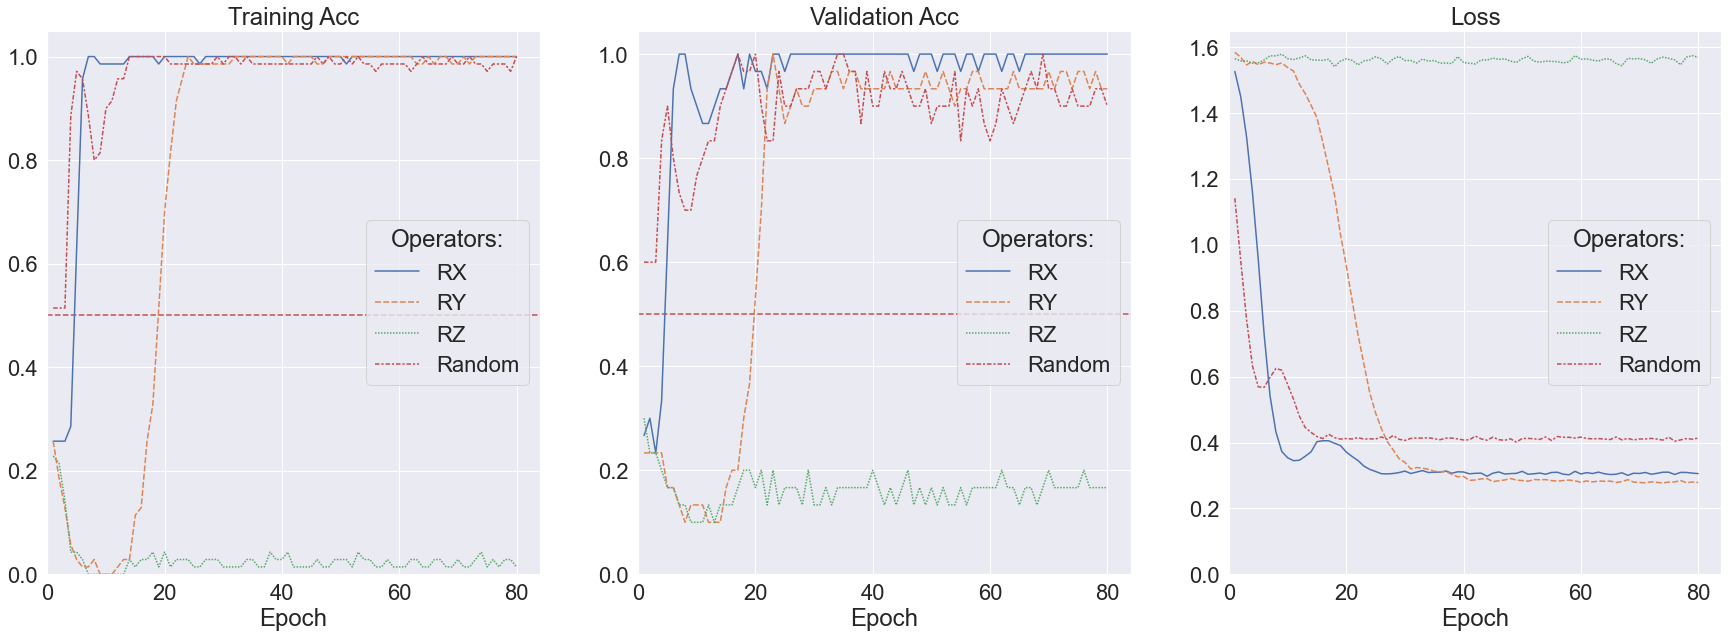

In [217]:
column_name = ['RX','RY','RZ','Random'] 
train_exp4 = lstToDf(mc_44rx_train,mc_44_ry_train,mc_44_rz_train,mc_44_rdm_train,colname=column_name)
val_exp4   = lstToDf(mc_44rx_val,mc_44_ry_val,mc_44_rz_val,mc_44_rdm_val,colname=column_name)
cost_exp4  = lstToDf(mc_44rx_loss,mc_44_ry_loss,mc_44_rz_loss,mc_44_rdm_loss,colname=column_name)

fig, ax = plt.subplots(1,3,figsize=(30,10))

for i in range(len(ax)):
    if i <= 1:
        ax[i].axhline(y=0.5, color='r',ls='dashed')

sns.lineplot(data=train_exp4,ax=ax[0]).set(title='Training Acc')
sns.lineplot(data=val_exp4,ax=ax[1]).set(title='Validation Acc')
sns.lineplot(data=cost_exp4,ax=ax[2]).set(title='Loss')

for c in ax:
    c.legend(loc='center right',title='Operators:')

plt.setp(ax, xlim=0,ylim=0)
plt.show()

--------------------
#### Experiment 2 Result

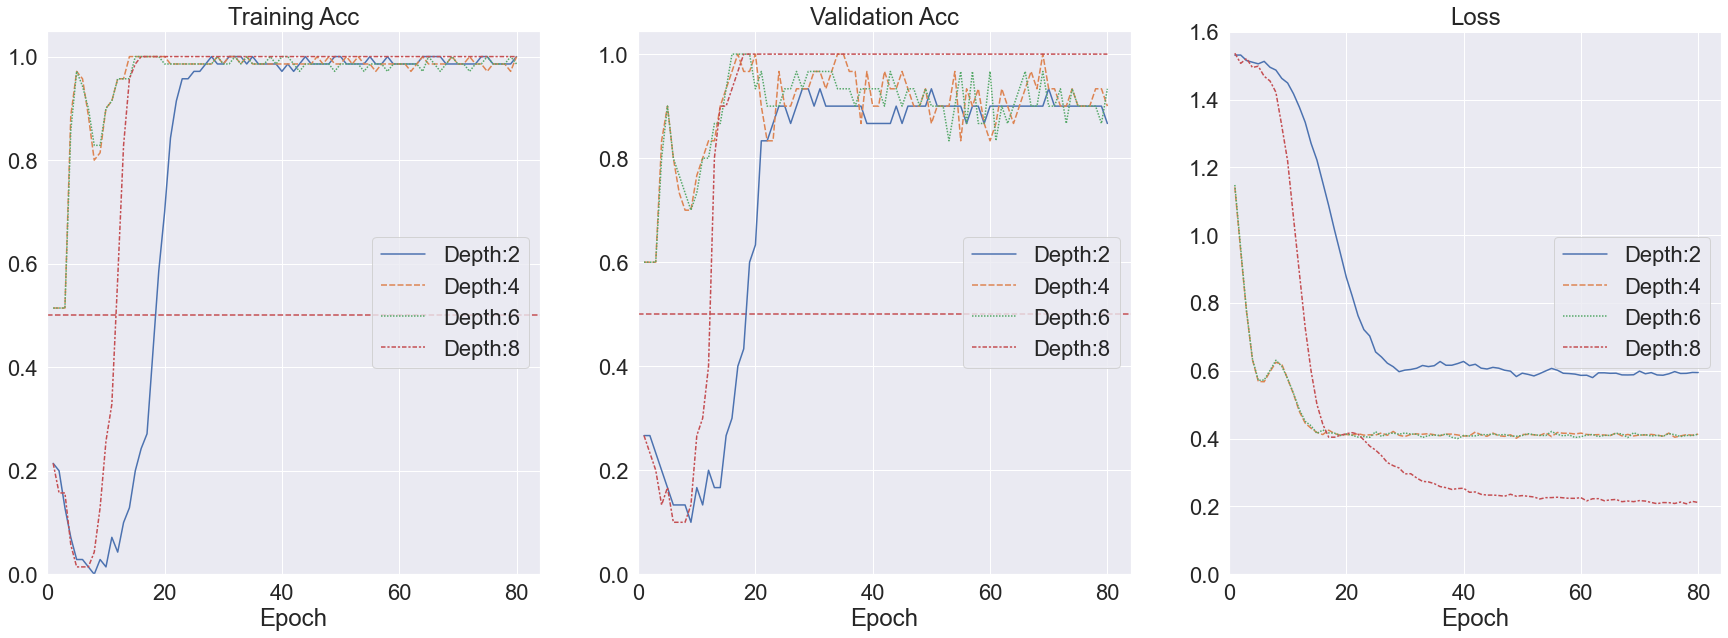

In [221]:
mc_42_train,mc_42_val,mc_42_loss
mc_44_rdm_train,mc_44_rdm_val,mc_44_rdm_loss

column_name = ['Depth:2','Depth:4','Depth:6','Depth:8'] 
train_exp4 = lstToDf(mc_42_train,mc_44_rdm_train,mc_46_train,mc_48_train,colname=column_name)
val_exp4   = lstToDf(mc_42_val,mc_44_rdm_val,mc_46_val,mc_48_val,colname=column_name)
cost_exp4  = lstToDf(mc_42_loss,mc_44_rdm_loss,mc_46_loss,mc_48_loss,colname=column_name)

fig, ax = plt.subplots(1,3,figsize=(30,10))

for i in range(len(ax)):
    if i <= 1:
        ax[i].axhline(y=0.5, color='r',ls='dashed')

sns.lineplot(data=train_exp4,ax=ax[0]).set(title='Training Acc')
sns.lineplot(data=val_exp4,ax=ax[1]).set(title='Validation Acc')
sns.lineplot(data=cost_exp4,ax=ax[2]).set(title='Loss')

for c in ax:
    c.legend(loc='center right')

plt.setp(ax, xlim=0,ylim=0)
plt.show()

-------------------------
#### Experiment 3 Result

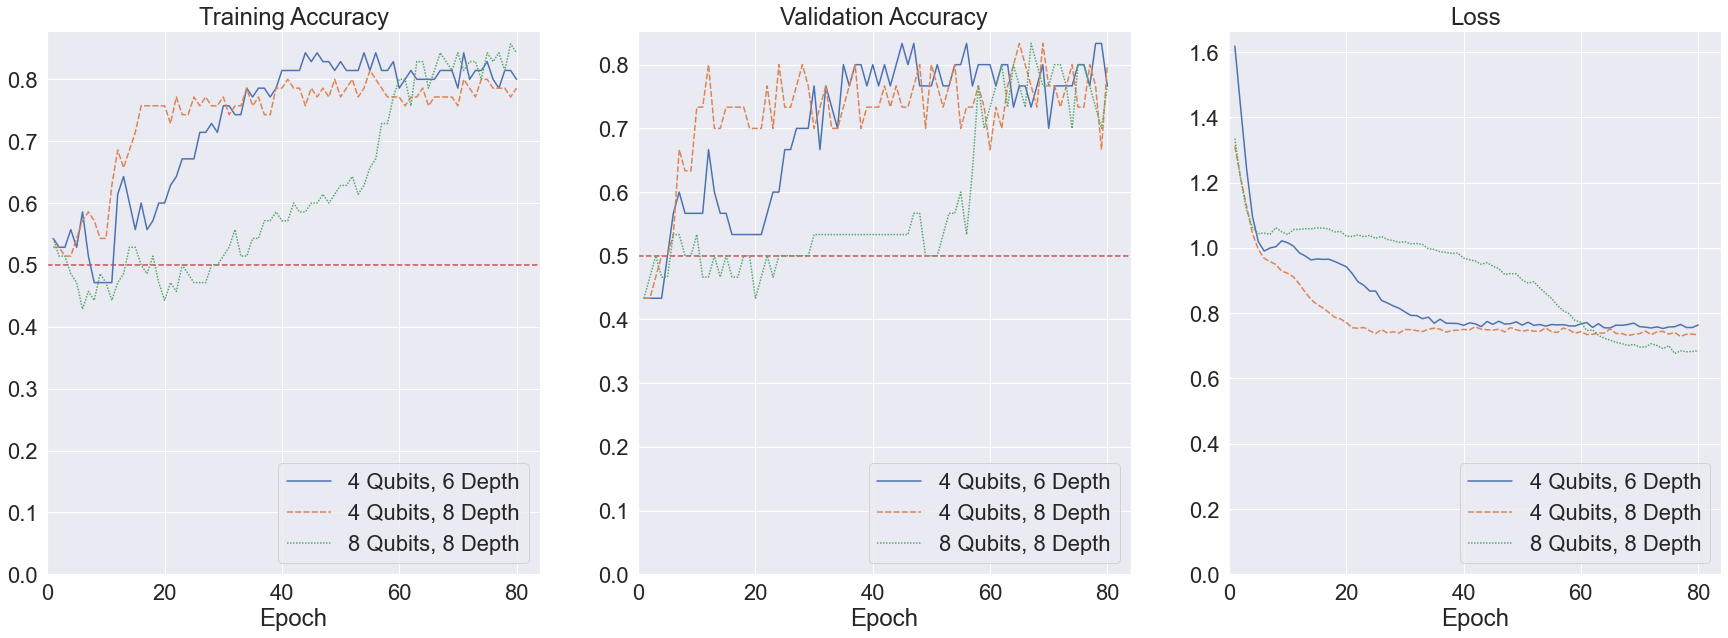

In [222]:
col_name = ['4 Qubits, 6 Depth','4 Qubits, 8 Depth','8 Qubits, 8 Depth']
ag_46_train,ag_46_val,ag_46_loss

train_exp3 = lstToDf(ag_46_train,ag_48_train,ag_88_train,colname=col_name)
val_exp3   = lstToDf(ag_46_val,ag_48_val,ag_88_val,colname=col_name)
cost_exp3  = lstToDf(ag_46_loss,ag_48_loss,ag_88_loss,colname=col_name)

fig, ax = plt.subplots(1,3,figsize=(30,10))

for i in range(len(ax)):
    if i <= 1:
        ax[i].axhline(y=0.5, color='r',ls='dashed')

sns.lineplot(data=train_exp3,ax=ax[0]).set(title='Training Accuracy')
sns.lineplot(data=val_exp3,ax=ax[1]).set(title='Validation Accuracy')
sns.lineplot(data=cost_exp3,ax=ax[2]).set(title='Loss')

for c in ax:
    c.legend(loc='lower right')

plt.setp(ax, xlim=0,ylim=0)
plt.show()

---------------------
#### Experiment full batch vs mini batch training result

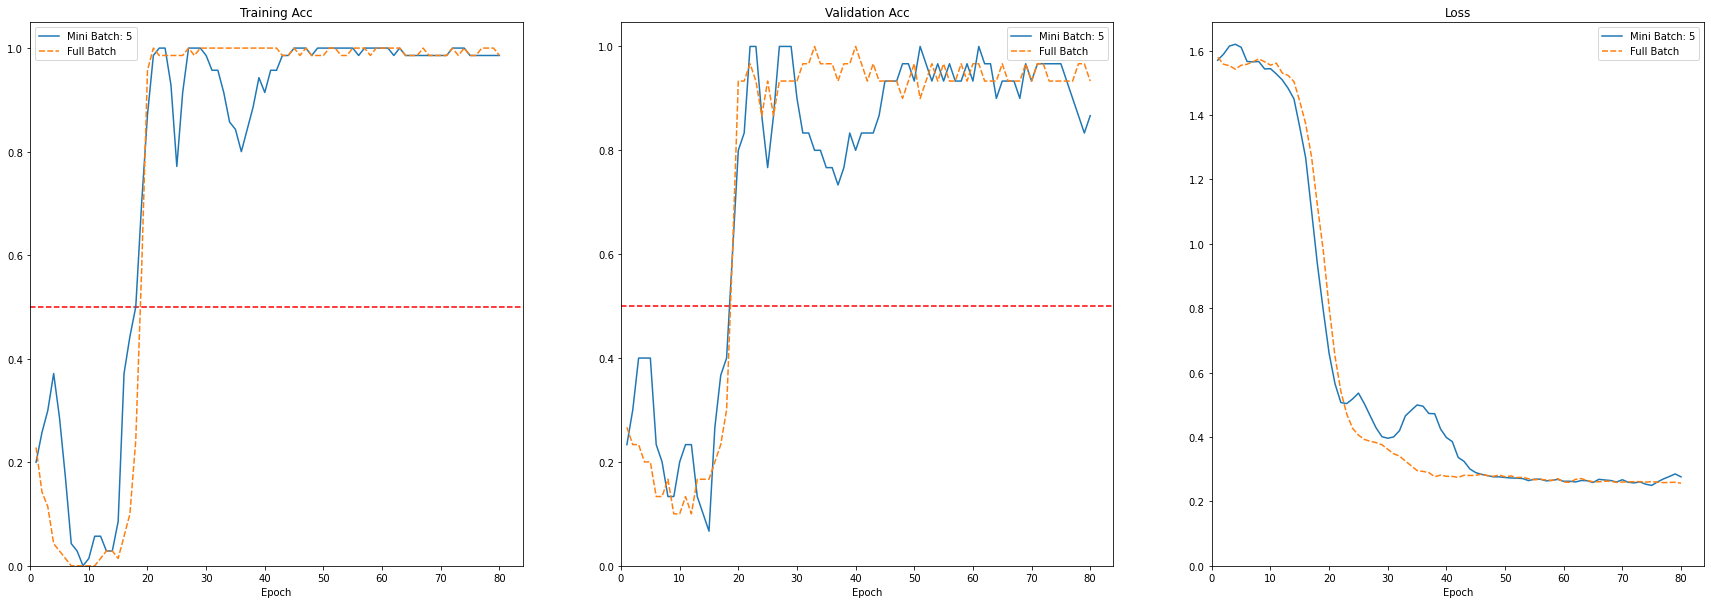

In [134]:
col_name=['Mini Batch: 5','Full Batch']
train_exp4 = lstToDf(mb5_44_train,fb_44_train,colname=col_name)
val_exp4   = lstToDf(mb5_44_val,fb_44_val,colname=col_name)
cost_exp4  = lstToDf(mb5_44_loss,fb_44_loss,colname=col_name)

fig, ax = plt.subplots(1,3,figsize=(30,10))

for i in range(len(ax)):
    if i <= 1:
        ax[i].axhline(y=0.5, color='r',ls='dashed')

sns.lineplot(data=train_exp4,ax=ax[0]).set(title='Training Acc')
sns.lineplot(data=val_exp4,ax=ax[1]).set(title='Validation Acc')
sns.lineplot(data=cost_exp4,ax=ax[2]).set(title='Loss')
plt.setp(ax, xlim=0,ylim=0)

plt.show()